## Hiragana
use CNN to learn and recognize hiraggana

In [318]:
import tensorflow
tensorflow.__version__


'2.7.0'

In [319]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils

#for CNN model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D


Import and organize data

In [320]:
## import data
img_test = cv.imread("hiragana-dataset-master/hiragana_images/kanaBA0.jpg", cv.IMREAD_GRAYSCALE)
(img_rows, img_cols) = img_test.shape


In [321]:
## extract the romanji from a filename
import re
# hiragana-dataset-master/hiragana_images/kanaBA0.jpg
def get_romanji(filename):
    keyword = re.search(r'kana(\w+?)\d+', filename).group(1)
    return keyword.lower()


In [322]:
## import data into a list
## construct datatable
import os
import pandas as pd

handwriting_list = []
dir_name = "hiragana-dataset-master/hiragana_images"
# os.listdir(dir_name)
for filename in os.listdir(dir_name):
    # print(f"{dir_name}/f{filename}.jpg")
    picture_label_list = [cv.imread(f"{dir_name}/{filename}", cv.IMREAD_GRAYSCALE), filename, get_romanji(filename)]
    handwriting_list.append(picture_label_list)
# print(handwriting_list)

handwriting_table = pd.DataFrame(handwriting_list, columns=["Handwriting", "Filename", "Romanji"])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU5.jpg,yu
996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU6.jpg,yu
997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU7.jpg,yu
998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU8.jpg,yu


In [324]:
## add labels to the datatable w.r.t. the romanji
def romanji_to_dict(S): # construct dict from Romanji series
    romanji_list = list(set(S))
    romanji_dict = {}
    for i, romanji in enumerate(romanji_list):
        romanji_dict[romanji] = i
    return romanji_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])
handwriting_table

,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a,14
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a,14
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a,14
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a,14
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a,14
...,...,...,...,...
995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU5.jpg,yu,8
996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU6.jpg,yu,8
997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU7.jpg,yu,8
998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU8.jpg,yu,8


In [334]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X.shape

(1000, 84, 83, 1)

In [335]:
## split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #shuffle=True
Y_train = np_utils.to_categorical(y_train, romanji_categories)
Y_test = np_utils.to_categorical(y_test, romanji_categories)
X_train.shape

(800, 84, 83, 1)

# Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [336]:
## standardize X_train and X_test
def std_X(X):
    X = X.astype('float32') / 255
    return X

X_train = std_X(X_train)
X_test = std_X(X_test)

# CNN Model
construct a CNN model

In [337]:
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',padding='same',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(romanji_categories, activation='softmax'))

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary:
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 84, 83, 32)        320       
                                                                 
 conv2d_24 (Conv2D)          (None, 84, 83, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 42, 41, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 42, 41, 64)        0         
                                                                 
 flatten_10 (Flatten)        (None, 110208)            0         
                                                                 
 dense_20 (Dense)            (None, 128)               14106752  
                                      

# Augmentation
Use the augmentation to generate more data from the training data.
Use rotate, height transform, width transform to simulate all kinds of handwritings

In [338]:
from keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


In [339]:
## train the model wuth data (including augmentaion datagen)
batch_size = 128
nb_epoch = 32

# generate data with datagen
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train, Y_train, batch_size=32, subset='training'),
         validation_data=datagen.flow(X_train, Y_train, batch_size=8, subset='validation'),
         batch_size=batch_size, epochs=nb_epoch, verbose=1)


Epoch 1/32
20/20 [==============================] - 10s 455ms/step - loss: 4.0023 - accuracy: 0.0500 - val_loss: 3.5819 - val_accuracy: 0.1875
Epoch 2/32
20/20 [==============================] - 9s 458ms/step - loss: 3.5320 - accuracy: 0.1328 - val_loss: 3.0685 - val_accuracy: 0.1813
Epoch 3/32
20/20 [==============================] - 10s 507ms/step - loss: 3.2218 - accuracy: 0.1984 - val_loss: 2.8352 - val_accuracy: 0.3938
Epoch 4/32
20/20 [==============================] - 9s 453ms/step - loss: 2.8084 - accuracy: 0.2750 - val_loss: 2.4102 - val_accuracy: 0.4750
Epoch 5/32
20/20 [==============================] - 8s 418ms/step - loss: 2.6346 - accuracy: 0.3141 - val_loss: 2.0730 - val_accuracy: 0.4875
Epoch 6/32
20/20 [==============================] - 8s 400ms/step - loss: 2.3170 - accuracy: 0.4016 - val_loss: 1.7551 - val_accuracy: 0.6375
Epoch 7/32
20/20 [==============================] - 9s 433ms/step - loss: 2.0715 - accuracy: 0.4516 - val_loss: 1.4325 - val_accuracy: 0.6562
Epoc

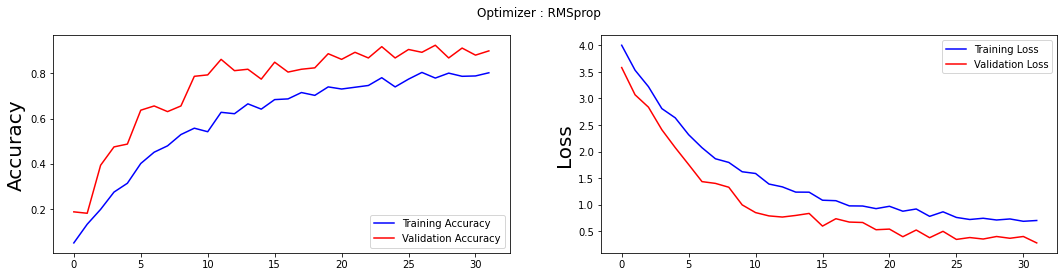

In [341]:
plt.figure(figsize=(18,4))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSprop', fontsize=12)
plt.ylabel('Accuracy', fontsize=20)
plt.plot(train_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=20)
plt.plot(train_history.history['loss'], color='b', label='Training Loss')
plt.plot(train_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

# Model Evaluation
evaluate the model with test data

In [342]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 76ms/step - loss: 0.0351 - accuracy: 0.9950
Test score: 0.03514285013079643
Test accuracy: 0.9950000047683716


{0: 'me', 1: 'ra', 2: 'ku', 3: 'se', 4: 'tsu', 5: 'ru', 6: 'mu', 7: 'wo', 8: 'yu', 9: 'te', 10: 'ro', 11: 'so', 12: 'sa', 13: 'ha', 14: 'a', 15: 'to', 16: 'chi', 17: 'ba', 18: 'ji', 19: 'ta', 20: 'nu', 21: 'n', 22: 'ne', 23: 'mi', 24: 'da', 25: 'i', 26: 'yo', 27: 're', 28: 'wa', 29: 'e', 30: 'ko', 31: 'ki', 32: 'fu', 33: 'pi', 34: 'shi', 35: 'mo', 36: 'ya', 37: 'no', 38: 'u', 39: 'ni', 40: 'ka', 41: 'ma', 42: 'o', 43: 'na', 44: 'hi', 45: 'ho', 46: 'ri', 47: 'ke', 48: 'su', 49: 'he'}
200


<ipython-input-350-0f13003d974a>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(num_test/num_eachrow, num_eachrow, i+1)


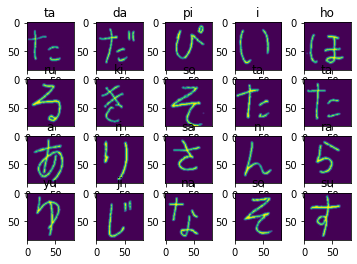

[19 24 33 25 45  5 31 11 19 19 14 46 12 21  1  8 18 43 11 48 38 23 20 11
 45 43 49 39 25 18 36  2 43  3 46 38 45 39 42  6 27 41 10 24 15 17 35 22
  5 23 38 30  1 31 49  9  5 42 37 26 11  6 29 48  4 48 23 24  8  0 17 47
 37 42 14 12 28 12 16 14 33 38 18 33 38 12 29 19 39 13  7 15 42 24 10 38
 11 30 19 42 28 25 27 13 19 15  2 15  0 20 43 24  1 31 32 40 21  7 45 16
  1 31  9 20  7 46 36 25 37 11  9 25  9  5 41  4 44 36  0  7 49 15 15 23
 28 18  9 39 16  8 21 15 23 16 34 10 35 13 32 25 20  1  0 26 34  9  2  3
 49 15 15 49 36 40 36 25 41  1 21  8 32 30 48 26  2 48 27 12 24 29 17 23
  9 46 22  5  9 48 44 24]
[19 24 33 25 45  5 31 11 19 19 14 46 12 21  1  8 18 43 11 48 38 23 20 11
 45 43 49 39 25 18 36  2 43  3 46 38 45 39 42  6 27 41 10 24 15 17 35 22
  5 23 38 30  1 31 49  9 10 42 37 26 11  6 29 48  4 48 23 24  8  0 17 47
 37 42 14 12 28 12 16 14 33 38 18 33 38 12 29 19 39 13  7 15 42 24 10 38
 11 30 19 42 28 25 27 13 19 15  2 15  0 20 43 24  1 31 32 40 21  7 45 16
  1 31  9 20  7 46 36 25 

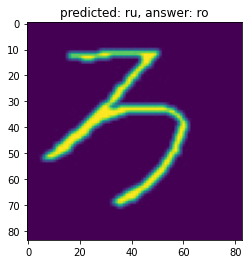

In [350]:
inv_romanji_dict = dict((v,k) for k,v in romanji_dict.items())

print(inv_romanji_dict)

nVal=X_test.shape[0]
print(nVal)
prob = model.predict(X_test)
# print(prob)
predictions=np.argmax(prob,axis=1)

# ax = plt.subplot(3, 4, i+1)
num_test = 20
num_eachrow = 5
for i in range(num_test):
    ax = plt.subplot(num_test/num_eachrow, num_eachrow, i+1)
    plt.title(inv_romanji_dict[predictions[i]])
    plt.imshow(X_test[i])
# plt.tight_layout()
plt.show()
# for X, prediction in zip(X_test, predictions):
#     plt.title(inv_romanji_dict[prediction])
#     plt.imshow(X)
#     plt.show()
print(predictions)
ground_truth=y_test
print(ground_truth)
#ground_truth=np.argmax(y_test[:],axis=1)
errors = np.where(predictions != ground_truth)[0]
print(errors)
print("Number of errors = {}/{}".format(len(errors),nVal))
for error in errors:
    plt.title(f"predicted: {inv_romanji_dict[predictions[error]]}, answer: {inv_romanji_dict[y_test[error]]}")
    plt.imshow(X_test[error])
    plt.show()

In [348]:
from keras.models import load_model
# creates a HDF5 file
model.save('model_hiragana_recognition_cnn.h5') 
